# Python - Loading and plotting ADCP data


**Aim:** To load and plot ADCP data from a `*.txt` files

**Data:** Download the data files from 

**Directions:** Create an `*.ipynb` and 2 figures: the sections of velocity.



<hr>

In [1]:
# Your code here
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import scipy.io as sio
from datetime import date
from read_ascii_data import *


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import palettable.colorbrewer.sequential as cbseq

from palettable.colorbrewer.sequential import Blues_8
from palettable.cartocolors.sequential import Sunset_7_r
from palettable.cartocolors.sequential import BluYl_7


In [2]:
# File paths
file_path = '/Users/eddifying/Dropbox/data/SeePrakt-data/2023-seepraktikum/adcp-data/ascii/'
filename = 'ascii_template_20230511_002_ASC_Analyse.TXT'
fname = file_path + filename
# Define index ranges and constants
INDEX_RANGES = {
    'date'      : (1, 7),
    'depth'     : (9, 150),
    'lat'       : 150,
    'lon'       : 151,
    'direction' : (152, 292),
    'magnitude' : (293, 433)
}

# Define NaN value
NAN_VALUE = -32768

ds = read_adcp_ascii_file( fname, 'UHH Sea Practical 2023', 'stnx', INDEX_RANGES, NAN_VALUE)

ds=ds.drop_vars('cruise')
ds=ds.drop_vars('station')

print(ds)


<xarray.Dataset>
Dimensions:    (time: 15440, depth: 140)
Coordinates:
  * time       (time) datetime64[ns] 2023-05-11T06:23:45 ... 2023-05-11T13:38:37
  * depth      (depth) float64 2.45 2.95 3.45 3.95 ... 70.45 70.95 71.45 71.95
Data variables:
    direction  (time, depth) float64 135.4 339.8 300.9 203.1 ... nan nan nan nan
    magnitude  (time, depth) float64 0.231 0.149 0.084 0.158 ... nan nan nan nan
    longitude  (time) float64 8.154 8.154 8.154 8.154 ... 8.16 8.16 8.16 8.16
    latitude   (time) float64 53.51 53.51 53.51 53.51 ... 53.52 53.52 53.52


## 1. Take a look at the data


In [3]:
print('Velocity magnitude vector is '+str(ds.magnitude.shape))
print('Time vector is '+str(ds.time.shape))
print('Depth vector is '+str(ds.depth.shape))

interval_secs = np.diff(ds.time).mean()/ np.timedelta64(1, 's')
print('Time interval in seconds is '+str(interval_secs))

Velocity magnitude vector is (15440, 140)
Time vector is (15440,)
Depth vector is (140,)
Time interval in seconds is 1.690005829


## 2. First start with a 5-minute average

The first method here creates a rolling average (also known as moving average or boxcar filter) for a 5-minute window (a typical window for ADCP averaging).  However, the `rolling` method results in a dataset which has the same dimensions as the original.

The second method resamples the data using an average (so also like a rolling average) over 5-minutes.  Now the dataset has become much compressed.

Note that in both cases, there is some time-shifting that is occurring.  In order to have data centered on the middle of the 5-minute average, we have had to do some additional calculations.

In the case of the rolling average, we've passed the option `center=True`

In the case of the resample, we've re-assigned the coordinates using `np.timedelta(minutes=2.5)`

In [4]:
# Find the window-length
NN = np.ceil(60*5 / interval_secs)
print(NN)

print('Using a filter window length of NN='+str(NN)+' to make 5-minute averages')

178.0
Using a filter window length of NN=178.0 to make 5-minute averages


In [7]:
# Calculate a rolling average
ds5min = ds.rolling(time=int(NN), center=True).mean()

# Resample onto a 5-minute average
ds5min_resample = ds.resample(time="5Min").mean(dim='time')
ds5min_resample = ds5min_resample.assign_coords({"time": ds5min_resample.time + pd.Timedelta(minutes=2.5)})

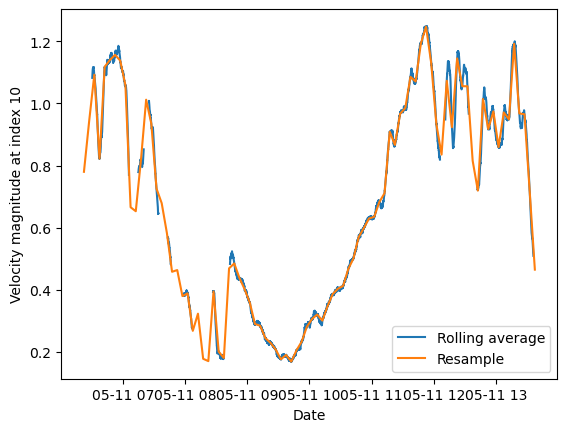

In [8]:
# Plot the outcome
fig, ax = plt.subplots()

line1, = ax.plot(ds5min.time,ds5min.magnitude[:,10])
line1.set_label('Rolling average')
line2, = ax.plot(ds5min_resample.time,ds5min_resample.magnitude[:,10])
line2.set_label('Resample')
plt.xlabel('Date')
plt.ylabel('Velocity magnitude at index 10')

plt.legend()

## 3. Now figure out what's where

In [9]:
# We've verified that the resample does what we want it to
# Now use this smaller data file for later plots
ds2 = ds5min_resample


### Make a map

Text(0, 0.5, 'Latitude')

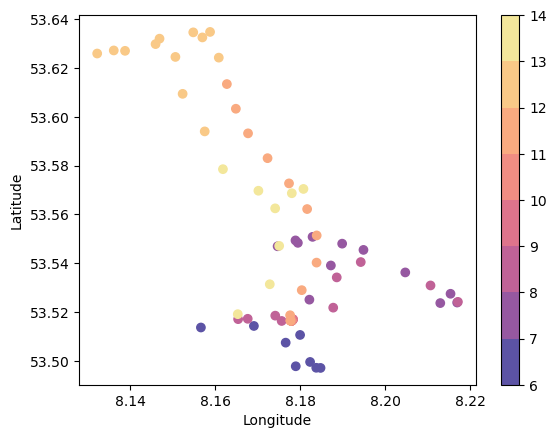

In [10]:
cmap = plt.cm.jet  # define the colormap
cmap = Sunset_7_r.mpl_colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)                               

# Hour start
tmin = mdates.date2num(ds2.time).min()
tmin = tmin-np.floor(tmin)
hourstart = np.floor(tmin*24)
# Hour end
tmax = mdates.date2num(ds2.time).max()
tmax = tmax-np.floor(tmax)
hourend = np.ceil(tmax*24)
numhours = int(hourend-hourstart+1)

hours = 24*(mdates.date2num(ds2.time)-np.floor(mdates.date2num(ds2.time).min()))

# define the bins and normalize
bounds = np.linspace(hourstart,hourend,numhours)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make a figure showing the location (lat/lon) and the hour when the ship was there (colour)
plt.scatter(ds2.longitude,ds2.latitude,c=hours,cmap=cmap,norm=norm)
cb=plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Make a section (or in this case, time depth plot) of velocity

In [13]:
print(ds2.depth.shape)
print(ds2.time.shape)
print(ds2.magnitude.shape)

(140,)
(88,)
(88, 140)


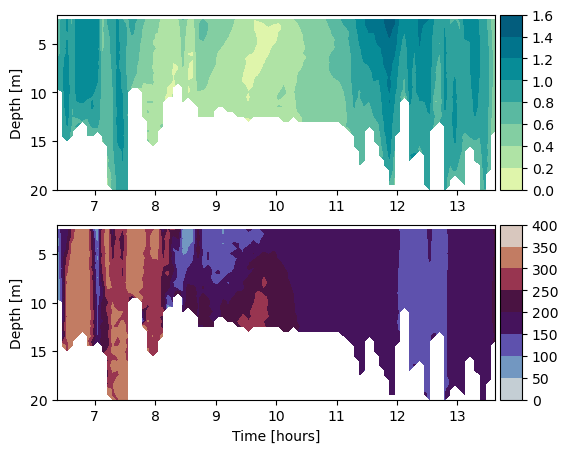

In [16]:
# Plot the magnitude against time (x) and depth (y)
fig = plt.figure(figsize=(6,5))

# Velocity magnitude
cmap = BluYl_7.mpl_colormap

ax1 = fig.add_subplot(211)
#cf1 = ax1.contourf(ds2.time,ds2.depth,ds2.magnitude.T, cmap=cmap)
cf1 = ax1.contourf(hours,ds2.depth,ds2.magnitude.T, cmap=cmap)
ax1.set_ylim((2,20))
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf1, cax=cax, orientation='vertical')

cmap = plt.cm.twilight

ax2 = fig.add_subplot(212)
cf2 = ax2.contourf(hours, ds2.depth, ds2.direction.T, cmap=cmap);

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf2, cax=cax, orientation='vertical');

ax2.set_xlabel('Time [hours]')
ax2.set_ylim((2,20))
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]')

fig.savefig('figures/adcp_section.png')

## 4. Where are velocities fast and slow?

Make a quiver plot of arrow vectors to see the u and v velocities.

In [48]:
# Test the transformation
veloMag = 1
veloDir = 0

u_velo = veloMag*np.cos(ds2


(88,)

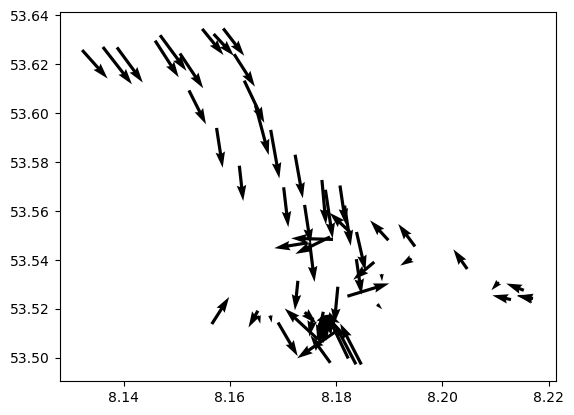

In [44]:
# Make a quiver plot
#https://stackoverflow.com/questions/19576495/color-matplotlib-quiver-field-according-to-magnitude-and-direction

u_velo = ds2.magnitude*np.sin(ds2.direction*np.pi/180)
v_velo = ds2.magnitude*np.cos(ds2.direction*np.pi/180)
#for ii in range(20,30):
for ii in range(10,11):
    x_dir1 = u_velo[:,ii]
    y_dir1 = v_velo[:,ii]
    plt.quiver(ds2.longitude, ds2.latitude, x_dir1, y_dir1)


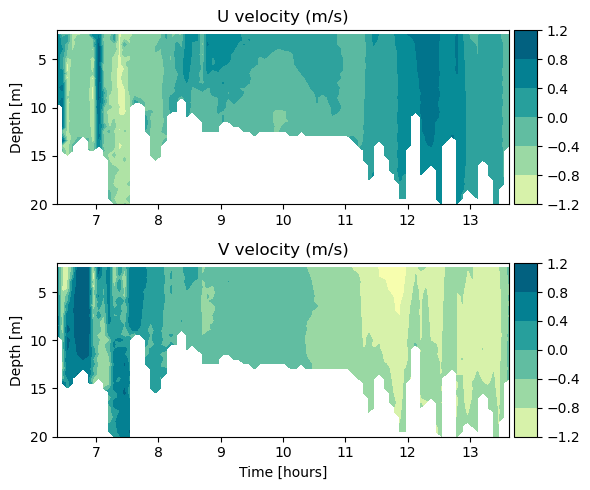

In [95]:
from matplotlib.cm import ScalarMappable

# Set some color axis limits, based on the data
vmin = -1.2
vmax = 1.2
levels=6
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# Choose a colormap
cmap = BluYl_7.mpl_colormap

# Create the figure
fig = plt.figure(figsize=(6,5))

# Upper panel for U-velocity
ax1 = fig.add_subplot(211)

# Contour the data
cf1 = ax1.contourf(hours,ds2.depth,u_velo.T,cmap=cmap)

# Set some annotations
ax1.set_ylim((2,20))
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]')
ax1.set_title('U velocity (m/s)')

# Add the colorbar 
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)

# Specify color limits
fig.colorbar(ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
                  cax=cax,
                  orientation='vertical',
                  boundaries=level_boundaries,
                  values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
                 )
ax2 = fig.add_subplot(212)

v_velo2 = v_velo.copy


cf2 = ax2.contourf(hours,ds2.depth,v_velo.T,
                   cmap=cmap,
                   vmin=vmin, vmax=vmax
                  )
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
                  cax=cax,
                  orientation='vertical',
                  boundaries=level_boundaries,
                  values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
                 )
ax2.set_title('V velocity (m/s)')
#cf2, cax=cax, 
ax2.set_xlabel('Time [hours]')
ax2.set_ylim((2,20))
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]')

fig.tight_layout()


#fig.colorbar(
#    ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
#    ticks=range(vmin, vmax+5, 5),
#    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
#)
